# Urban Sound Classification (Hidden Markov Model)

All sound files (5435) are in Traindata folder. 
Train.csv has all the file names 

In [2]:
#Dependencies
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import librosa
import librosa.display as disp
import os, os.path
import natsort
import csv
from hmmlearn import hmm
import shutil
import time
from python_speech_features import mfcc
import itertools
from sklearn.metrics import confusion_matrix

## Pre-Processing

### Create a dataframe with audio file names and label

In [3]:
if(os.path.isdir("Traindata")):
    files = os.listdir("Traindata/")
else:
    print("Directory doesn't exist..")
Training_Files = natsort.natsorted(files) 

print(f'Total number of audio files is {len(Training_Files)}')
#Read Label File
label_names = pd.read_csv('train.csv')

try:
    shutil.rmtree('testdata/')
except:
    print("Test Data directory doesn't exist...so continuing")

try:
    shutil.rmtree('data/')
except:
    print("Data directory doesn't exist...so continuing")


Total number of audio files is 5435


In [4]:
df = pd.DataFrame({'File':Training_Files})

In [5]:
data = pd.concat([label_names, df], axis=1, join_axes=[label_names.index])
data.head()

,ID,Class,File
0,0,siren,0.wav
1,1,street_music,1.wav
2,2,drilling,2.wav
3,3,siren,3.wav
4,4,dog_bark,4.wav


### Get the duration of each file and append to dataframe. 90% of the files have durations between 3.5 to 4 sec. If files with duration greater than 3.5 is taken Gun-Shot class is left with only one file. Hence sound files are used with default length

In [6]:
length = []
for files in(Training_Files):
    file = os.path.join('Traindata/',files)
    length.append(librosa.get_duration(filename=file))
data = pd.concat([data, pd.DataFrame({'Duration':length})], axis=1, join_axes=[label_names.index])
data.head()

,ID,Class,File,Duration
0,0,siren,0.wav,4.0
1,1,street_music,1.wav,4.0
2,2,drilling,2.wav,4.0
3,3,siren,3.wav,4.0
4,4,dog_bark,4.wav,4.0


In [7]:
classes = data['Class'].unique()

In [8]:
classes

array(['siren', 'street_music', 'drilling', 'dog_bark',
       'children_playing', 'gun_shot', 'engine_idling', 'air_conditioner',
       'jackhammer', 'car_horn'], dtype=object)

**As seen above there are 10 different classes of sounds**

### Partition and move all sound files into their respective class folder

In [9]:
cwd = os.getcwd()
for index, row in data.iterrows():
    if not (os.path.isdir('data')):
        os.mkdir('data')
    label = os.path.join('data/',row["Class"])
    file_name = os.path.join('Traindata/',row["File"])
    if not (os.path.isdir(label)):
        os.mkdir(label)
    shutil.copy(file_name,label)
        

### We have 10 folders for each class containing audio files corresponding to that class

In [10]:
labels = [x for x in os.listdir("data") if not x.startswith('.')]
print(labels)

['siren', 'car_horn', 'gun_shot', 'drilling', 'street_music', 'children_playing', 'air_conditioner', 'dog_bark', 'engine_idling', 'jackhammer']


### Let's observe the count of files in each category/class

In [11]:
for i in (labels):
    file_path = os.path.join('data/',i)
    print(f'Size of {i} is {len(os.listdir(file_path))}')

Size of siren is 607
Size of car_horn is 306
Size of gun_shot is 230
Size of drilling is 600
Size of street_music is 600
Size of children_playing is 600
Size of air_conditioner is 600
Size of dog_bark is 600
Size of engine_idling is 624
Size of jackhammer is 668


### Split Test set. Move 50 files from each category to testdata folder

In [12]:
if not (os.path.isdir('testdata')):
        os.mkdir('testdata')
for i in(labels):
    testlabel = os.path.join('testdata/',i)
    if not (os.path.isdir(testlabel)):
        os.mkdir(testlabel)
    for j in range(50):
        source_path = os.path.join('data/',i)
        source_files = os.listdir(source_path)
        index = random.randrange(0, len(source_files))
        source_file = os.path.join(source_path,source_files[index])
        shutil.move(source_file,testlabel)
print("Test files moved...")

Test files moved...


In [13]:
for i in (labels):
    file_path = os.path.join('data/',i)
    print(f'Size of {i} is {len(os.listdir(file_path))}')

Size of siren is 557
Size of car_horn is 256
Size of gun_shot is 180
Size of drilling is 550
Size of street_music is 550
Size of children_playing is 550
Size of air_conditioner is 550
Size of dog_bark is 550
Size of engine_idling is 574
Size of jackhammer is 618


## Feature Extraction

We are extracting three features for our classification:

1. **MFCC:** Sounds generated by a human are filtered by the shape of the vocal tract. The shape of the vocal tract manifests itself in the envelope of the short time power spectrum, and the job of MFCCs is to accurately represent this envelope.

2. **MFCC Delta:** Local estimate of the derivative of the input data along the Time axis

3. **MFCC Delta Delta:** Local estimate of the second order derivative of the input data along the Time axis

Other features like Chroma, Tonnetz , zero crossing rates were tried but didn't improve the results. These features are more related to musical notes.

In [14]:
def extract_feature(filepath):
    
    X,sampling_rate = librosa.load(filepath)
    mfcc = librosa.feature.mfcc(y=X ,sr=sampling_rate,n_mfcc=24)
    mfcc_delta = librosa.feature.delta(mfcc,mode='nearest')
    mfcc_delta_delta = librosa.feature.delta(mfcc,mode='nearest',order=2)
    features = np.vstack((np.vstack((mfcc,mfcc_delta)),mfcc_delta_delta))
    return features.T

In [15]:
def plot_wave(labels,path):
    
    fig = plt.figure(figsize=(20,20))

    for index,label in enumerate(labels): 
        train_file = os.listdir(os.path.join(path,label))
        file = os.path.join(os.path.join(path,label),train_file[index])
        X,sampling_rate = librosa.load(file)
        fig.add_subplot(5,2,index+1)
        plt.title(label)
        disp.waveplot(X,sampling_rate,x_axis='none')

def plot_spectrogram(labels,path):
    
    fig = plt.figure(figsize=(20,20))

    for index,label in enumerate(labels): 
        train_file = os.listdir(os.path.join(path,label))
        file = os.path.join(os.path.join(path,label),train_file[index])
        X,sampling_rate = librosa.load(file)
        ps = librosa.feature.melspectrogram(y=X, sr=sampling_rate)
        fig.add_subplot(5,2,index+1)
        plt.title(label)
        disp.specshow(ps, y_axis='mel', x_axis='time')
        

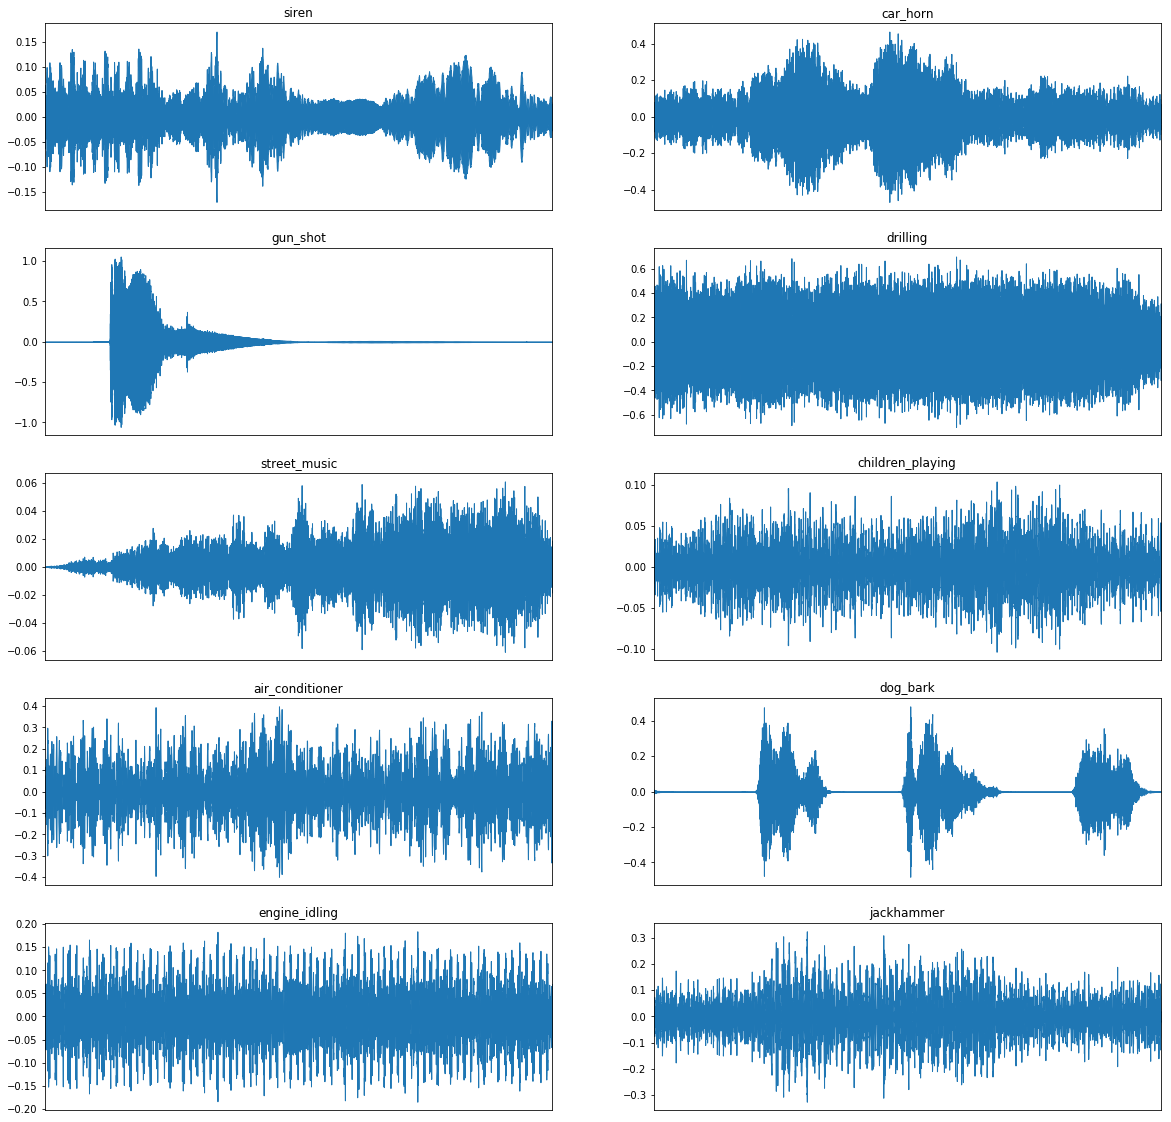

In [16]:
plot_wave(labels,'data/')

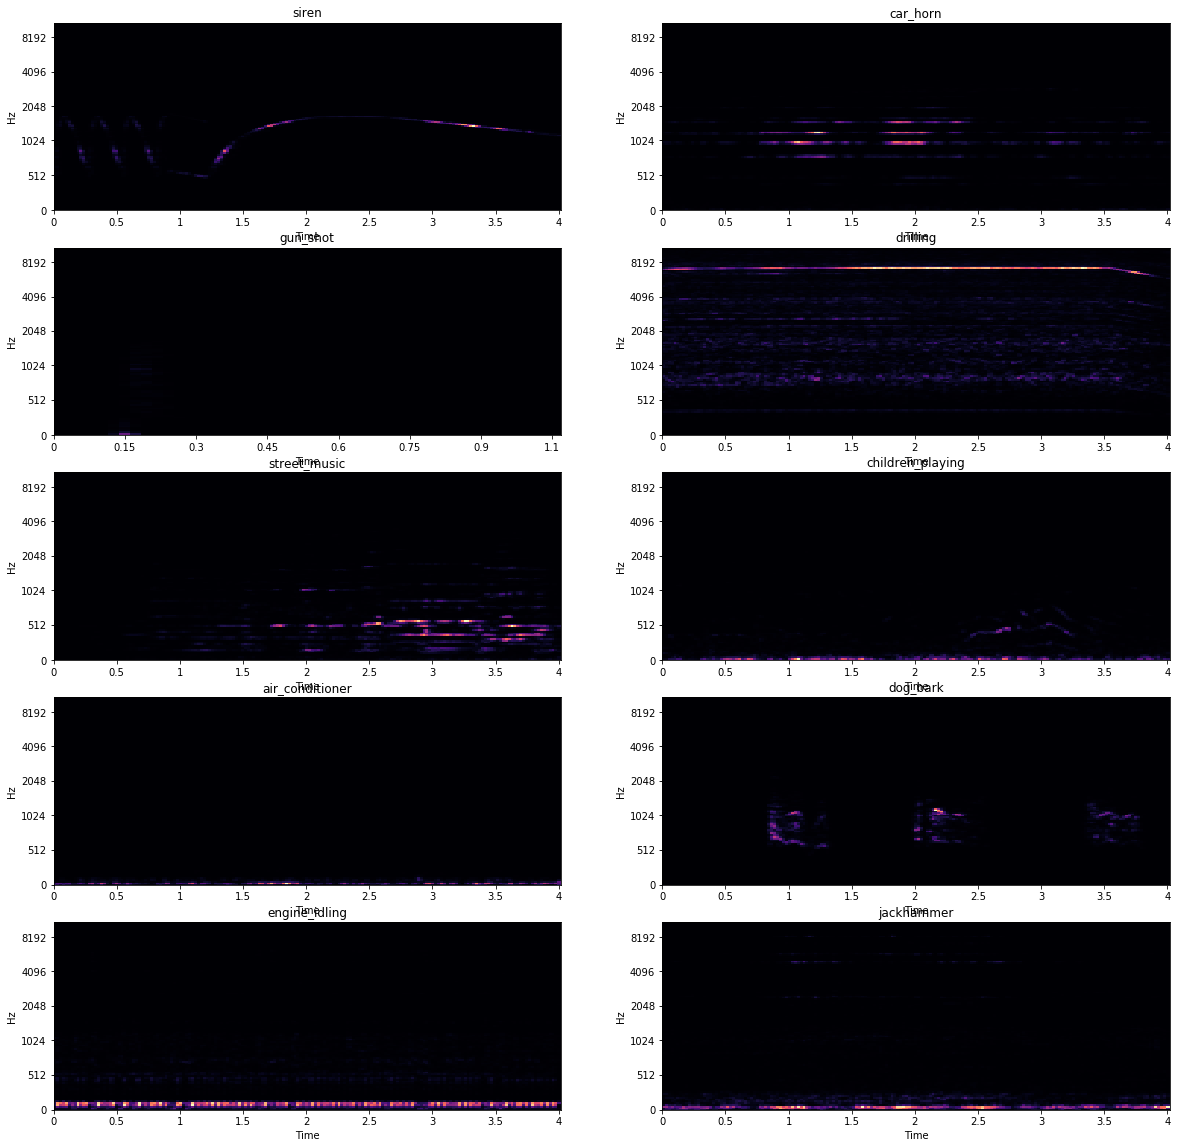

In [17]:
plot_spectrogram(labels,'data/')

## HMM model Class (Fit and Predict methods)

In [18]:
class Train_HMM():
    
    def __init__(self,number_of_components, epochs):
        
        self.number_of_components = number_of_components
        self.epochs = epochs
        self.models = []
        self.prediction = []
        self.labels = []
    
    def fit(self,x):
        hmm_model = hmm.GMMHMM(n_components = self.number_of_components,n_iter=self.epochs)
        self.models.append(hmm_model.fit(x))
        return hmm_model
    
    def predict(self,test_directory):
        
        Accuracy = pd.DataFrame(columns=['Class', 'Accuracy'])
        predicted_class = []
        test_data_size = 500  # We have taken 50 files from each 10 classes
        for folders in (test_directory):
            test_path = os.path.join('testdata/',folders)
            test_files = natsort.natsorted(os.listdir(test_path))
            for files in (test_files):
                file = os.path.join(test_path,files)
                mfcc_features = extract_feature(file)
                max_score = float("-inf")
                for item,label in zip(self.models,labels):
                    score = item.score(mfcc_features)
                    if score > max_score:
                        max_score = score
                        output_label = label
                predicted_class.append(output_label)
        return predicted_class

## Training

In [19]:
number_of_components = 12
epochs = 1000
hmm_model = Train_HMM(number_of_components,epochs)
tic = time.time()
for i in (labels):
    X = np.array([])
    train_path = os.path.join('data/',i)
    train_files = os.listdir(train_path)
    
    for index,val in enumerate(train_files):
        
        file_name = os.path.join(train_path,val)
        if len(X) == 0:
            X = extract_feature(file_name)
        else:
            X = np.append(X, extract_feature(file_name), axis=0)
    print(f'Shape of X is {X.shape}')
    hmm_model.fit(X)
    print(f'Training of {i} is complete')

toc = time.time()

print(f'Time taken to train is {toc-tic}')
    
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)


Shape of X is (94658, 72)
Training of siren is complete
Shape of X is (29510, 72)
Training of car_horn is complete
Shape of X is (11938, 72)
Training of gun_shot is complete
Shape of X is (82886, 72)
Training of drilling is complete
Shape of X is (95150, 72)
Training of street_music is complete
Shape of X is (94228, 72)
Training of children_playing is complete
Shape of X is (95015, 72)
Training of air_conditioner is complete
Shape of X is (74134, 72)
Training of dog_bark is complete
Shape of X is (97912, 72)
Training of engine_idling is complete
Shape of X is (95775, 72)
Training of jackhammer is complete
Time taken to train is 3294.688966989517


In [20]:
hmm_model.models

[GMMHMM(algorithm='viterbi', covariance_type='diag',
     covars_prior=array([[[-1.5, -1.5, ..., -1.5, -1.5]],
 
        [[-1.5, -1.5, ..., -1.5, -1.5]],
 
        ...,
 
        [[-1.5, -1.5, ..., -1.5, -1.5]],
 
        [[-1.5, -1.5, ..., -1.5, -1.5]]]),
     covars_weight=array([[[0., 0., ..., 0., 0.]],
 
        [[0., 0., ..., 0., 0.]],
 
        ...,
 
        [[0., 0., ..., 0., 0.]],
 
        [[0., 0., ..., 0., 0.]]]),
     init_params='stmcw',
     means_prior=array([[[0., 0., ..., 0., 0.]],
 
        [[0., 0., ..., 0., 0.]],
 
        ...,
 
        [[0., 0., ..., 0., 0.]],
 
        [[0., 0., ..., 0., 0.]]]),
     means_weight=array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
     min_covar=0.001, n_components=12, n_iter=1000, n_mix=1, params='stmcw',
     random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
     verbose=False,
     weights_p

In [21]:
labels

['siren',
 'car_horn',
 'gun_shot',
 'drilling',
 'street_music',
 'children_playing',
 'air_conditioner',
 'dog_bark',
 'engine_idling',
 'jackhammer']

## Results: Testing our HMM model with test data

### Get the true labels for Test Data

In [22]:
test_directory = os.listdir('testdata/')
True_Label = []
for folders in (test_directory):
    folder_path = os.path.join('testdata/',folders)
    folder_files = natsort.natsorted(os.listdir(folder_path))
    for i in range(len(folder_files)):
        True_Label.append(folders)

### Get the prediction for Test Data

In [23]:
prediction = hmm_model.predict(test_directory)

### Calculate Accuracy

In [24]:
match = [i for i, j in zip(prediction, True_Label) if i == j]
Accuracy = len(match)*100/len(True_Label)
Accuracy

86.6

## Plot Confusion matrix

In [25]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
Normalized confusion matrix


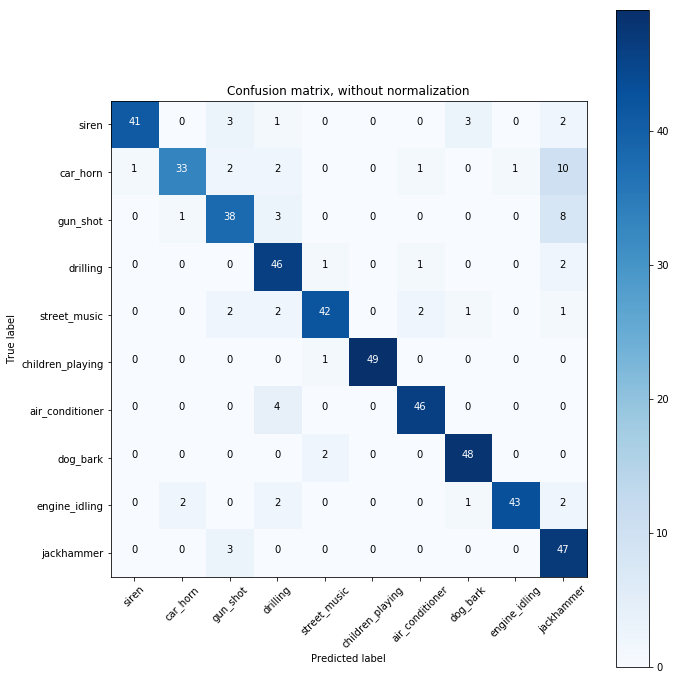

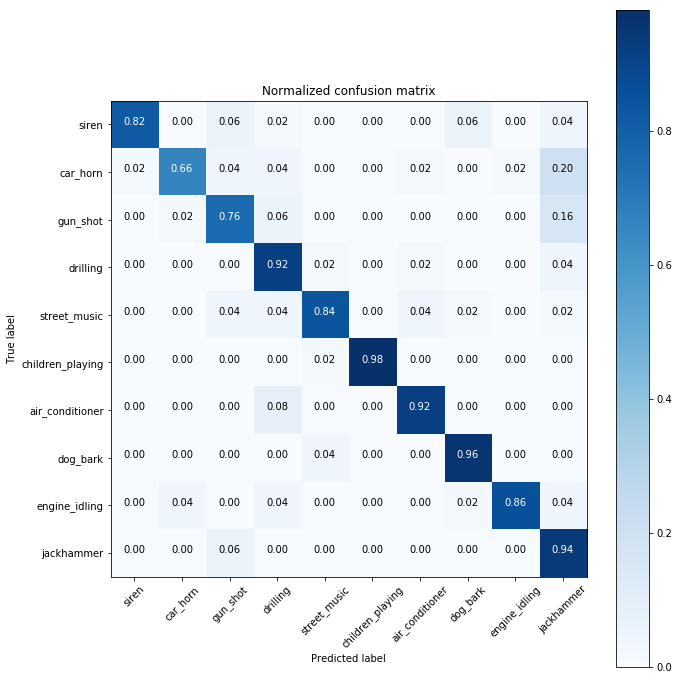

In [26]:
cnf_matrix = confusion_matrix(True_Label, prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Conclusion

This dataset has sounds from 10 classes which are of different durations and recorded differently. There are many factors which could be more experimented with to achieve better accuracy:

1) White Noise: There are noise contaminations in the files so proper de-noising before training could give better results.

2) Sound classes with similar spectrogram: As shown in spectrogram for all the classes, few have very similar spectrogram which crteated confusion. For example, car_horn was confused with Jackhammer 6 times out of 50.

3) Three features MFCC, Delta and Delta Delta were used which gave best results. Several other features were experimented with like Chroma, Tonnetz etc but they didn't improve the performance. More experiments need to be done with features in future
